# Variational Auto-Encoder (VAE)

> In this tutorial, we will build a *variational* autoencoder for MNIST.
>
> WIP!

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm, trange
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms.v2 import ToTensor, Normalize, Compose, ToImage, ToDtype

In [2]:
# load the dataset with help from torchvision

transform = Compose([
    # formerly used ToTensor, which is decaprecated now
    # transforms images to torchvision.tv_tensors_Image
    ToImage(),
    # with scale=True, scales pixel intensities from [0,255] to [0.0,1.0]
    ToDtype(torch.float32, scale=True),
    # could normalize the pixel intensity value to overall mean and std of train set
    # Normalize([0.1307], [0.3081]),
])

train_ds = MNIST("data/", train=True, download=True, transform=transform)
test_ds = MNIST("data/", train=False, download=True, transform=transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, n_latent=2, *args, **kwargs):
        """Our Encoder: compresses the input image to a low-dimensional representation."""
        super().__init__(*args, **kwargs)
        # how many dimensions our latent space has
        self.n_latent = n_latent
        
        self.conv = nn.Sequential(
            # shape: (N,1,28,28)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), padding=2),
            # shape: (N,8,28,28)
            nn.MaxPool2d((2,2)),
            # shape: (N,8,14,14)
            # batch norms will help to stabilize and speed up training
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # shape: (N,8,14,14)
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(5,5), padding=2),
            # shape: (N,8,14,14)
            nn.MaxPool2d((2,2)),
            nn.BatchNorm2d(8),
            # shape: (N,8,7,7)
            nn.ReLU(),
            # shape: (N,8,7,7)
            # nn.Flatten(),
        )

        # predicts mean        
        self.linear_mu = nn.Sequential(
            # shape: (N,392)
            nn.Linear(392, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, self.n_latent)
            # no activation function!
        )

        # predicts logarithmic variance
        self.linear_logvar = nn.Sequential(
            # shape: (N,392)
            nn.Linear(392, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, self.n_latent)
            # no activation function here!
        )
 
    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = x.flatten(start_dim=1)

        mu = self.linear_mu(x)
        logvar = self.linear_logvar(x)
        return mu, logvar

In [4]:
class Decoder(nn.Module):
    def __init__(self, n_latent=2, *args, **kwargs):
        """Our Decoder: acts inversely to the encoder and decompresses the latent representation back into an image."""
        super().__init__(*args, **kwargs)
        self.n_latent = n_latent
        self.linear = nn.Sequential(
            nn.Linear(self.n_latent, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 392),
            nn.BatchNorm1d(392),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(8, 8, (5,5), padding=2, stride=2, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # output_padding does not actually add 0s around the output, just increases the size
            nn.ConvTranspose2d(8, 1, (5,5), padding=2, stride=2, output_padding=1),
            # apply sigmoid to map to [0,1]
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor):
        # input shape (N, 10)
        x = self.linear(x)
        # reshape x to the right dimensions
        x = x.unflatten(1, (8,7,7))
        # transposed convolution
        x = self.deconv(x)
        return x

In [ ]:
class VAE(nn.Module):
    def __init__(self, encoder_kwargs=None, decoder_kwargs=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        encoder_kwargs = dict() if encoder_kwargs is None else encoder_kwargs
        decoder_kwargs = dict() if decoder_kwargs is None else decoder_kwargs

        self.encoder = Encoder(**encoder_kwargs)
        self.decoder = Decoder(**decoder_kwargs)
    
    def sample(self, mu, logvar):
        # get standard deviation
        sigma = torch.exp(0.5 * logvar)
        # reparameterization trick: neither mu nor sigma is used for sampling
        noise = torch.randn_like(mu)
        z = mu + sigma * noise
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.sample(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, z, mu, logvar

# Training

- for a proof of the Kullback Leibler Divergence for Normal Distributions, see: https://statproofbook.github.io/P/norm-kl.html

![Equation 10 from Kingma](figures/kingma_eq_10.png)

In [50]:
from torch.nn import MSELoss
from torch.nn import BCELoss
from torch.optim import Adam

def train_vae(model: nn.Module, train_dl: DataLoader, n_epochs: int = 5, lr=1e-4, log_interval=10, beta=1):
    model.train()
    loss_log = list()

    # criterion_reco = MSELoss()
    criterion_bce = BCELoss(reduction="sum")
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in trange(n_epochs):
        for i, (x, _) in enumerate(train_dl):
            optimizer.zero_grad()
            x_reco, _, mu, logvar = model(x)
            # reco_loss = criterion_reco(x, x_reco)
            # binary cross entropy as likelihood
            loss_bce = criterion_bce(x_reco, x)
            # the equation below directly results from the KLD between the latent distribution and N(0,1)
            loss_kld = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum()
            loss = loss_bce + beta * loss_kld
            loss.backward()
            if i % log_interval == 0:
                loss_log.append(loss.item())
            optimizer.step()
    return loss_log


In [51]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

In [ ]:
BETA = 1
N_EPOCHS = 10

In [53]:
model = VAE()

train_loss = train_vae(model, train_dl, n_epochs=N_EPOCHS, beta=BETA)

100%|██████████| 5/5 [03:42<00:00, 44.59s/it]


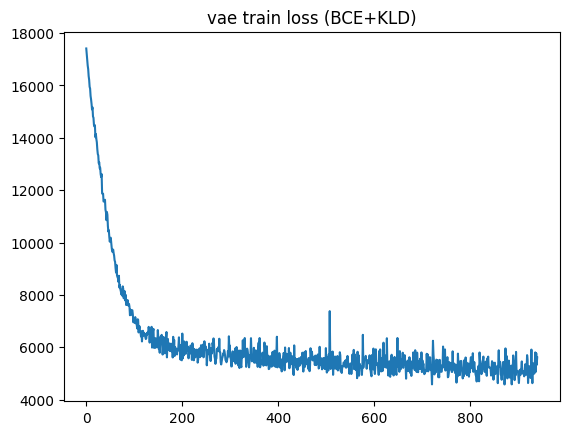

In [56]:
plt.plot(train_loss)
plt.title("vae train loss (BCE+KLD)");

In [57]:
n_test = 10

x_test = torch.stack([train_ds[i][0] for i in range(n_test)])
y_test = torch.tensor([train_ds[i][1] for i in range(n_test)])

In [58]:
model.eval()

with torch.no_grad():
    x_hat, z_test, mu_test, logvar_test = model(x_test)

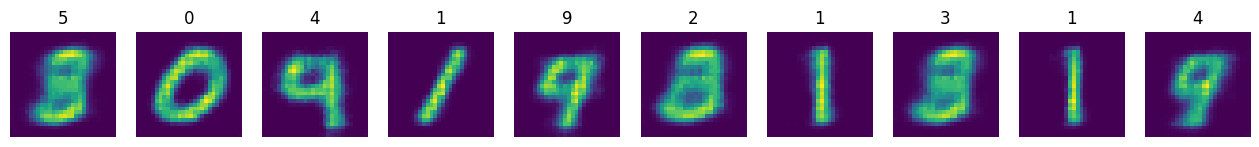

In [59]:
plt.figure(figsize=(16,4))

for i, x in enumerate(x_hat):
    plt.subplot(1, n_test, i+1)
    plt.imshow(x.squeeze())
    plt.title(y_test[i].item())
    plt.axis(False)

# Bookmarks

- https://lilianweng.github.io/posts/2018-08-12-vae/
    - amazing overview on Autoencoders in general with nice figures
- https://github.com/ludovicobuizza/gan_vae
- 